In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from functools import lru_cache

In [2]:
# Clear GPU memory before starting
def clear_gpu_memory():
    try:
        from numba import cuda
        device = cuda.get_current_device()
        device.reset()
    except:
        pass
    # Clear TensorFlow session
    tf.keras.backend.clear_session()
    # Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            try:
                tf.config.experimental.set_memory_growth(device, True)
                print(f"Memory growth enabled for GPU device: {device}")
            except:
                print("Error enabling memory growth")

clear_gpu_memory()

In [ ]:
def test_unet_on_image(image_path, unet_model, target_size=(256, 256)):
    """
    Tests the U-Net lung segmentation model on a single chest X-ray and 
    gets segmented lungs.
    """
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if image was loaded successfully
    if img is None:
        raise FileNotFoundError(f"Could not open or find the image: {image_path}")
        
    original_img = img.copy()  # Keep a copy of the original image
    img_resized = cv2.resize(img, target_size)  # Resize to match model input

    # Normalize image for model prediction
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=(0, -1))  # Add batch & channel dims

    # Predict lung mask
    lung_mask = unet_model.predict(img_input)[0, :, :, 0]  # Remove batch dim
    lung_mask = (lung_mask > 0.5).astype(np.uint8)  # Apply thresholding

    # Apply mask to extract lungs
    segmented_lungs = img_resized * lung_mask

    # Convert grayscale to BGR for colored border overlay
    segmented_colored = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

    # Find contours (to draw borders)
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the segmented image (Red border)
    cv2.drawContours(segmented_colored, contours, -1, (0, 0, 255), 2)

    return original_img, img_resized, lung_mask, segmented_colored, segmented_lungs

def get_gradcam_densenet(model, img_array, pred_index=None, layer_name='conv5_block32_concat'):
    """
    Computes GradCAM by directly accessing internal layers of the DenseNet component
    Works for both DenseNet121 and DenseNet201
    """
    # Find the target layer - first check if model has a base densenet layer
    try:
        base_densenet = model.get_layer('densenet121') if 'densenet121' in [layer.name for layer in model.layers] else model
    except:
        base_densenet = model  # Use the model itself if no base layer found
    
    # Try to get the specified layer
    try:
        target_layer = base_densenet.get_layer(layer_name)
        print(f"Using layer: {layer_name}")
    except ValueError:
        # If exact layer not found, print available layers and use the last conv layer
        print(f"Layer {layer_name} not found. Available layers:")
        conv_layers = []
        for i, layer in enumerate(base_densenet.layers):
            print(f"{i}: {layer.name}")
            if 'conv' in layer.name:
                conv_layers.append(layer)
        
        if conv_layers:
            target_layer = conv_layers[-1]
            print(f"Using {target_layer.name} as target layer")
        else:
            # Fallback to last layer before output
            target_layer = base_densenet.layers[-2]
            print(f"Using {target_layer.name} as target layer")
    
    # Create the gradient model
    try:
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[target_layer.output, model.output]
        )
    except:
        # If that fails, try with a different approach
        all_layers = [layer.name for layer in model.layers]
        print(f"Model layers: {all_layers}")
        # Try with the last convolutional layer
        for layer_name in reversed(all_layers):
            if 'conv' in layer_name:
                try:
                    target_layer = model.get_layer(layer_name)
                    grad_model = tf.keras.models.Model(
                        inputs=model.inputs,
                        outputs=[target_layer.output, model.output]
                    )
                    print(f"Using layer {layer_name} as fallback")
                    break
                except:
                    continue
    
    # Apply GradCAM calculation
    with tf.GradientTape() as tape:
        # Forward pass to get activations and predictions
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            # For binary classification, use the first output
            class_channel = predictions[:, 0]
        else:
            class_channel = predictions[:, pred_index]
    
    # Get gradients of the class output with respect to the feature maps
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight feature maps with gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Apply ReLU to focus on features that have a positive effect on the class
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) if tf.math.reduce_max(heatmap) > 0 else heatmap
    
    return heatmap.numpy()

def classify_pneumonia_with_densenet(image, model, layer_name='conv5_block32_concat'):
    """
    Classify pneumonia using DenseNet (works for both DenseNet121 and DenseNet201)
    and generate GradCAM heatmap.
    
    Args:
        image: Preprocessed image (should be lung segmentation)
        model: Loaded DenseNet model
        layer_name: Layer to use for Grad-CAM
        
    Returns:
        prediction: Pneumonia probability
        heatmap: Grad-CAM heatmap
        image_3channel: Original image in 3 channels
        class_label: "PNEUMONIA" or "NORMAL"
    """
    # Convert grayscale to 3-channel if needed
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        image_3channel = np.stack((image,) * 3, axis=-1)
    else:
        image_3channel = image
        
    # Ensure image is in the right shape (224, 224, 3)
    if image_3channel.shape[:2] != (224, 224):
        image_3channel = cv2.resize(image_3channel, (224, 224))
    
    # Normalize pixel values
    img_array = image_3channel / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Get model prediction
    prediction = model.predict(img_array)[0][0]
    class_label = "Tuberculosis" if prediction > 0.5 else "NORMAL"
    
    # Use our more robust GradCAM function
    try:
        heatmap = get_gradcam_densenet(model, img_array, layer_name=layer_name)
    except Exception as e:
        print(f"Error in GradCAM generation: {e}")
        # Create empty heatmap as fallback
        heatmap = np.zeros((7, 7), dtype=np.float32)
    
    # Handle case where heatmap is empty or has NaN values
    heatmap = np.nan_to_num(heatmap).astype(np.float32)
    
    # Normalize heatmap if it's not empty
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    # Safely resize the heatmap
    try:
        # Convert to proper type for resize
        heatmap = heatmap.astype(np.float32)
        if heatmap.size > 0 and not np.isnan(heatmap).any():
            # Resize to match input image dimensions
            heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        else:
            # Create an empty heatmap of the desired size
            heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    except Exception as e:
        print(f"Error resizing heatmap: {e}")
        print(f"Heatmap shape: {heatmap.shape}, dtype: {heatmap.dtype}")
        # Create an empty heatmap as fallback
        heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    
    return prediction, heatmap, image_3channel, class_label

def calculate_infection_percentage(heatmap, lung_mask, threshold=0.2):
    """
    Calculate the percentage of lung area that shows infection.
    """
    heatmap = np.nan_to_num(heatmap).astype(np.float32)

    if heatmap.shape != lung_mask.shape:
        heatmap = cv2.resize(heatmap, (lung_mask.shape[1], lung_mask.shape[0]))

    activation_mask = (heatmap > threshold).astype(np.uint8)
    lung_area = np.sum(lung_mask)
    infection_area = np.sum(activation_mask * lung_mask)

    print(f"Lung Area: {lung_area}")
    print(f"Infection Area: {infection_area}")
    print(f"Infection Percentage: {(infection_area / lung_area * 100) if lung_area > 0 else 0:.2f}")

    # # Optional debugging visualization
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(12, 3))
    # plt.subplot(1, 3, 1)
    # plt.imshow(lung_mask, cmap='gray')
    # plt.title("Lung Mask")
    # plt.subplot(1, 3, 2)
    # plt.imshow(activation_mask, cmap='hot')
    # plt.title("Activation Mask")
    # plt.subplot(1, 3, 3)
    # plt.imshow(activation_mask * lung_mask, cmap='hot')
    # plt.title("Overlap (Infection)")
    # plt.show()

    return (infection_area / lung_area) * 100 if lung_area > 0 else 0.0


def apply_gradcam_to_segmented_lungs(original_img, heatmap, lung_mask, alpha=0.5, threshold=0.3):
    """
    Applies the GradCAM heatmap directly on the original X-ray with green lung contours.
    """
    # Ensure heatmap is valid and convert to float32
    heatmap = np.nan_to_num(heatmap).astype(np.float32)
    
    # Convert original image to RGB if it's grayscale
    if len(original_img.shape) == 2:
        img_rgb = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    else:
        img_rgb = original_img.copy()
        
    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    
    # Resize lung mask if needed
    if lung_mask.shape != original_img.shape:
        lung_mask_resized = cv2.resize(lung_mask, (original_img.shape[1], original_img.shape[0]))
    else:
        lung_mask_resized = lung_mask.copy()
    
    # Only apply heatmap within lungs
    masked_heatmap = heatmap_resized * lung_mask_resized
    
    # Threshold the heatmap to highlight only significant areas
    masked_heatmap = np.where(masked_heatmap > threshold, masked_heatmap, 0)
    
    # Create heatmap as red overlay (apply red channel)
    heatmap_overlay = np.zeros_like(img_rgb)
    heatmap_overlay[:, :, 2] = (masked_heatmap * 255).astype(np.uint8)  # Red channel
    
    # Find contours of the lung mask
    contours, _ = cv2.findContours(lung_mask_resized.astype(np.uint8), 
                                  cv2.RETR_EXTERNAL, 
                                  cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw green contours on the original image
    result = img_rgb.copy()
    cv2.drawContours(result, contours, -1, (0, 255, 0), 2)  # Green contours
    
    # Overlay the heatmap
    result = cv2.addWeighted(result, 1.0, heatmap_overlay, alpha, 0)
    
    return result

def display_pneumonia_visualization(original_img, lung_mask, gradcam_overlay, prediction, infection_percentage):
    """
    Displays a pneumonia visualization.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB))
    
    # Extract prediction class
    is_pneumonia = "Tuberculosis" if prediction > 0.5 else "Normal"
    plt.title(f"{is_pneumonia}\nInfection Percentage: {infection_percentage:.2f}", 
              fontsize=12, color='purple')
    
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def display_full_results(original_img, lung_mask, segmented_lungs, gradcam_overlay, prediction, infection_percentage):
    """
    Displays all results in a single figure.
    """
    plt.figure(figsize=(10, 8))

    # # Original X-ray Image
    # plt.subplot(1, 4, 1)
    # plt.imshow(original_img, cmap="gray")
    # plt.title("Original X-ray")
    # plt.axis("off")

    # # Lung Mask (Predicted)
    # plt.subplot(1, 4, 2)
    # plt.imshow(lung_mask, cmap="gray")
    # plt.title("Lung Mask")
    # plt.axis("off")

    # # Segmented Lungs
    # plt.subplot(1, 4, 3)
    # plt.imshow(segmented_lungs, cmap="gray")
    # plt.title("Segmented Lungs")
    # plt.axis("off")

    # GradCAM Visualization
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB))
    if prediction <= 0.5:  # Normal case
        plt.title(f"Normal\nAttention Area: {infection_percentage:.2f}")
    else:  # TB case
        plt.title(f"Tuberculosis\nInfection: {infection_percentage:.2f}")
    
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def analyze_xray_with_densenet(image_path, unet_model, densenet_model, grad_cam_layer=None):
    """
    Analyze a single X-ray image using DenseNet model for classification
    and display comprehensive results.
    
    Parameters:
        image_path: Path to the X-ray image
        unet_model: Lung segmentation model
        densenet_model: Pneumonia classification model (DenseNet)
        grad_cam_layer: Layer to use for GradCAM visualization (auto-detected if None)
    """
    print(f"Processing image: {os.path.basename(image_path)}")
    

    # Get the segmented lung mask and the segmented image
    original_img, resized_img, lung_mask, segmented_colored, segmented_lungs = test_unet_on_image(
        image_path, unet_model)
    
    # Classify pneumonia and get GradCAM heatmap
    prediction, heatmap, lung_3channel, class_label = classify_pneumonia_with_densenet(
        segmented_lungs, densenet_model, layer_name=grad_cam_layer)
    
    # Use different thresholds based on predicted class
    if prediction > 0.5:  # Tuberculosis
        threshold = 0.3
    else:  # Normal
        threshold = 0.6  # Higher threshold for normal cases
    # Calculate infection percentage
    infection_percentage = calculate_infection_percentage(heatmap, lung_mask, threshold = threshold)

    # Apply GradCAM to segmented lungs
    gradcam_overlay = apply_gradcam_to_segmented_lungs(
        resized_img, heatmap, lung_mask)
    
    # Display the results
    print(f"Prediction: {prediction}")
    print(f"Class: {class_label}")
    print(f"Infection Percentage: {infection_percentage:.2f}")
    
    # Show all visualizations
    display_full_results(
        resized_img, lung_mask, segmented_lungs, gradcam_overlay, prediction, infection_percentage)
    
    return {
        "prediction": prediction,
        "infection_percentage": infection_percentage,
        "visualization": gradcam_overlay,
        "class_label": class_label
    }

def demo_densenet_gradcam(image_path, model_type='densenet201'):
    """
    Demonstrates the use of GradCAM with DenseNet on a sample chest X-ray.
    
    Parameters:
        image_path: Path to chest X-ray image
        model_type: Either 'densenet121' or 'densenet201'
    """
    # Clear GPU memory
    
    # Load models
    unet_model = load_model(r'D:\varun\Major project\Major Project\lung_segmentation_unet.h5')
    densenet_model = load_model(r'D:\varun\Major project\Major Project\DenseNet201_TB_2.h5')
    
    # Determine appropriate layer for GradCAM
    if model_type.lower() == 'densenet121':
        grad_cam_layer = 'conv5_block16_concat'
    elif model_type.lower() == 'densenet201':
        grad_cam_layer = 'conv5_block32_concat'
    else:
        grad_cam_layer = None  # Auto-detect
    
    # Run the analysis
    try:
        results = analyze_xray_with_densenet(
            image_path, 
            unet_model, 
            densenet_model, 
            grad_cam_layer=grad_cam_layer
        )
        return results
    except Exception as e:

        # Try with auto-detection
        print("\nRetrying with auto-detection of layers...")
        return analyze_xray_with_densenet(
            image_path, 
            unet_model, 
            densenet_model, 
            grad_cam_layer=None  # Auto-detect
        )

Processing image: Tuberculosis-689.png
1/1 [==============================] - 75s 75s/step
Using layer: conv5_block32_concat
Lung Area: 22158
Infection Area: 9059
Infection Percentage: 40.88
Prediction: 0.264404296875
Class: NORMAL
Infection Percentage: 40.88


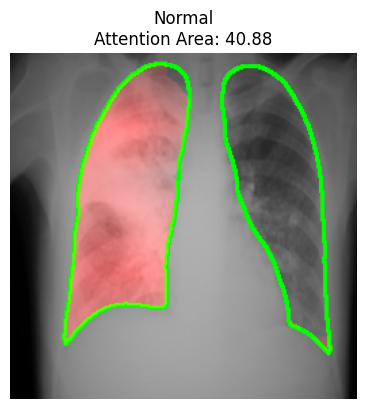


Analysis Results:
Prediction: 0.264404296875
Class Label: NORMAL
Infection Percentage: 40.88


In [ ]:
# Example usage
results = demo_densenet_gradcam(
        image_path,
        model_type='densenet201'  # Specify the model type you're using
)
    
print("\nAnalysis Results:")
print(f"Prediction: {results['prediction']}")
print(f"Class Label: {results['class_label']}")
print(f"Infection Percentage: {results['infection_percentage']:.2f}")